In [5]:
import cmocean
import numpy as np 
import xarray as xr
from scipy import signal
from scipy import integrate
from thermal import plotting
import matplotlib.colors as cm
import matplotlib.pyplot as plt 
from thermal.derived_fields import (calc_length, 
                                    Variable_at_ELA)

from thermal.utils import calc_Temp
plt.rcParams.update({'font.size': 10, 
                     'text.usetex': True, 
                     'text.latex.preamble' : r"\usepackage{amsthm, bm}"})

def calc_accum_flux(ds, z_ELA=2275):
    """Calculate the integrated flux, from the accumulation zone as a func of time
    """
    # calculate depth averaged velocity (m a-1)
    u_bar = ds.vel_m.mean('coord_2')
    # exract need fields along the free surface
    sub = ds[['height', 'X', 'Z']].isel(coord_2=-1)
    # where surfce elevation is in the accumulation zone, 
    # calculate the flux otherwise return zero
    flux = xr.where(sub.Z >= 2275, sub.height*u_bar, 0.0)
    # intergate the flux from the accumulation zone (m^2 yr-1)
    cum_flux = xr.apply_ufunc(integrate.trapz,
                              flux,
                              sub.X,
                              input_core_dims=[["coord_1"], ["coord_1"]],
                              kwargs={"axis": -1},
                              dask="parallelized")
    # (km^2 yr-1) <-- (m^2 yr-1)
    return cum_flux/1e6

def calc_flux_at_ELA(src): 
    # ice thickness at the ELA
    h_ELA = Variable_at_ELA(src, 'height').isel(coord_2=-1)
    # depth averaged velocity at the ELA
    u_bar = Variable_at_ELA(src, 'vel_m').mean('coord_2')
    
    # flux hm^2 yr-1
    return h_ELA*u_bar /1e4

In [121]:
src_fp = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/result/crmpt12/gridded/crmpt12_dx_50_TT_6000.0_MB_-0.37_OFF_Tma_-8.5_B_2.371e-04_SP_2_QP_28.zarr'

# start time 
t_0 = 2500
# end time 
t_f = 4000
# timestep 
dt  = 0.1 
# numer of timestep 
NT = int((t_f - t_0) / dt) + 1
# interpolated time axis 
t_interp = np.linspace(t_0+dt, t_f+dt, NT)

time_slices = [3060.5, 3150.5, 3300.5]

# get the time indexes associated with the surges
y = np.arange(0.1, 2.0, 0.1)[None,:] # start and end timestep of surge
x = np.arange(t_0+20, t_f+20, 30)[:, None]
surge_timesteps = (x + y).flatten()

In [122]:
surge_timesteps[::19]

array([2520.1, 2550.1, 2580.1, 2610.1, 2640.1, 2670.1, 2700.1, 2730.1,
       2760.1, 2790.1, 2820.1, 2850.1, 2880.1, 2910.1, 2940.1, 2970.1,
       3000.1, 3030.1, 3060.1, 3090.1, 3120.1, 3150.1, 3180.1, 3210.1,
       3240.1, 3270.1, 3300.1, 3330.1, 3360.1, 3390.1, 3420.1, 3450.1,
       3480.1, 3510.1, 3540.1, 3570.1, 3600.1, 3630.1, 3660.1, 3690.1,
       3720.1, 3750.1, 3780.1, 3810.1, 3840.1, 3870.1, 3900.1, 3930.1,
       3960.1, 3990.1])

In [76]:
# open the full dataset 
src = xr.open_zarr(src_fp)
# interpolate the time axis to constant dt, and rechunk the data
src = src.interp(t=t_interp, method='linear').chunk()
# src = src.sel(t=slice(t_0, t_f))

In [77]:
# extract the fraction temperate timeseries as it's own dataset
timeseries = (src.percent_temperate/100).rename('fraction_temperate').to_dataset()
# compute the annual average of the percent temperate for plotting 
timeseries['fraction_temperate'] = timeseries.fraction_temperate.rolling(t=10, center=True, min_periods=1).mean('t')
# compute the length, from a subset of the datavariables which are loaded into memory
timeseries['length'] = calc_length(src[['height', 'X']].compute()) * 1e3
# compute the ice thickness at the ELA
timeseries['h_at_ELA'] = Variable_at_ELA(src, 'height').compute().isel(coord_2=-1)
# compute dh/dt at the ELA 
timeseries['dhdt_ELA'] = timeseries.h_at_ELA.differentiate('t')
# compute the flux across the ELA 
timeseries['Q_at_ELA'] = calc_flux_at_ELA(src)
# flip the x-coord so the glacier flows left to right
X = src.X.sortby('coord_1', ascending=False).compute()
# get the horizontal gridcell spacing (~50 m) 
dx = np.abs(X.isel(coord_2=-1).diff('coord_1').mean())

# mask of active horizontal nodes
mask_active = (X <= timeseries['length'])
# compute spatial average of surfacce velocity, at the active nodes
timeseries['vel_mean'] = src.vel_m.where(mask_active).isel(coord_2=-1).mean('coord_1')
# compute maximum surface velocity, at the active nodes
timeseries['vel_max']  = src.vel_m.where(mask_active).isel(coord_2=-1).max('coord_1')
# compute the intergrated flux from the accumulation zone 
timeseries['accum_flux'] = calc_accum_flux(src).compute()
# extract the basal enthalpy [kJ kg-1]
ω_basal = src['water content'].compute().isel(coord_2=0)
# mask of temperate basal nodes 
mask_temperate = (ω_basal >= 0.001)
# compute the fraction of temperate bed [-]
timeseries['temperate_bed'] = (ω_basal.where(mask_active.isel(coord_2=-1) & 
                                             mask_temperate).count('coord_1') * dx) / timeseries['length']

In [84]:
idx, _ = signal.find_peaks(timeseries.fraction_temperate, height=0.35, width=100)
period = timeseries.t[idx].diff('t').mean()

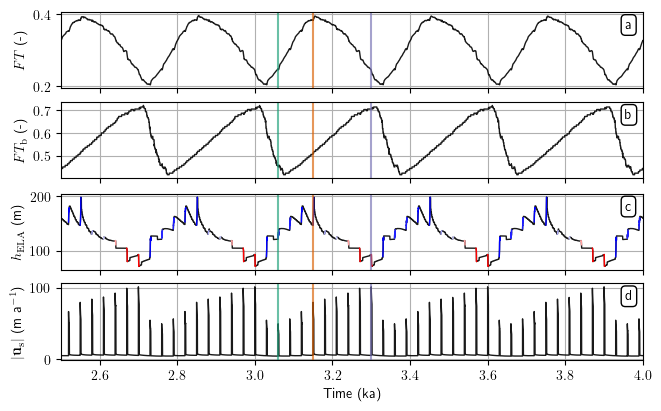

In [134]:
fig, ax = plt.subplots(4,1, sharex=True, figsize=(6.5,4), 
                       sharey=False, constrained_layout=True)

style = dict(lw = 1.0, c='k', alpha=0.90) 

ax[0].plot(timeseries.t/1e3, timeseries.fraction_temperate, **style)
# ax[0,0].scatter(timeseries.isel(t=idx).t/1e3, timeseries.isel(t=idx).fraction_temperate)
ax[1].plot(timeseries.t/1e3, timeseries.temperate_bed, **style)
ax[2].plot(timeseries.t/1e3, timeseries.h_at_ELA, **style)
ax[3].plot(timeseries.t/1e3, timeseries.vel_mean, **style)

###################################################
# annotations to h_ELA to highlight "step-like" changes due to the surge events
norm = cm.Normalize(vmin=-10, vmax=10)
cmap = plt.cm.bwr_r

sub = timeseries.h_at_ELA.sel(t=surge_timesteps, method='nearest')

for surge_slice in surge_timesteps.reshape(50, 19): 
    sub = timeseries.h_at_ELA.sel(t=surge_slice, method='nearest')
    dhdt = (sub.isel(t=-1) - sub.isel(t=0))/(sub.t.isel(t=-1) - sub.t.isel(t=0))    
    
    ax[2].plot(sub.t/1e3, sub, color=cmap(norm(dhdt)), lw=1.0)
###################################################


labels = ['a', 'b', 'c', 'd']
# colors = ['tab:red', 'tab:orange', 'tab:blue']
colors = ['#1b9e77','#d95f02','#7570b3']
for i in range(len(ax)): 
    pos = (0.97, 0.75)
    ax[i].text(*pos, labels[i], 
              ha='left', va='bottom', transform=ax[i].transAxes, 
              bbox=dict(boxstyle="round", fc='w') )
    
    for j, t in enumerate(time_slices): 
        ax[i].axvline(t/1e3, alpha=0.65,  c=colors[j]) 
        
    # ax[i].axvspan(3.06, 3.39, color='k', alpha=0.15)

# add gridlines to subplots
for i in range(4): 
    ax[i].grid()

# ax[3].set_ylim(0.0, 100)
ax[3].set_xlim(t_0/1e3, t_f/1e3)


ax[0].set_ylabel(r'$FT$ (-)')
ax[1].set_ylabel(r'$FT_{\rm b}$ (-)')
ax[2].set_ylabel(r'$h_{\rm ELA}$ (m)')
ax[3].set_ylabel(r'$\left| \bar \mathbf{u}_{\rm s} \right|$ (m a$^{-1}$)')
ax[3].set_xlabel('Time (ka)')

fig.savefig('../figs/crmpt12/periodicity_explainer_timeseries.pdf')

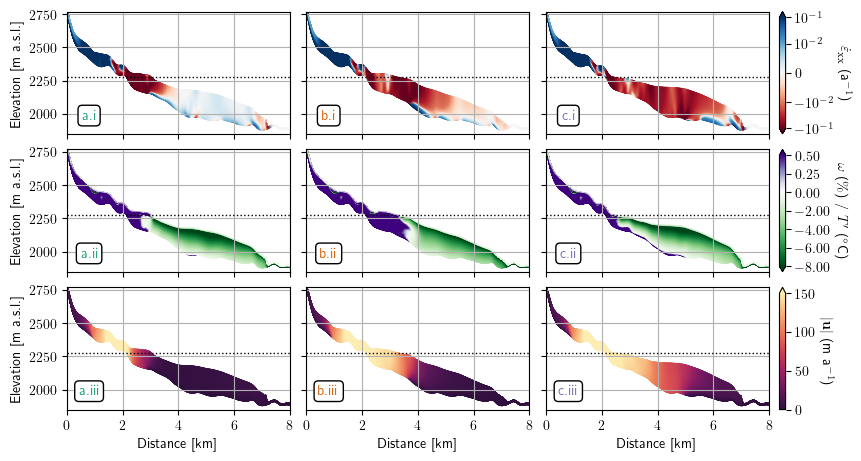

In [135]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, 
                       figsize=(8.5, 4.5), 
                       constrained_layout=True)

cell_centers = { 
    'coord_2' : np.linspace(0.0, 15,  50)
    }

labels = ['a', 'b', 'c']
colors = ['#1b9e77','#d95f02','#7570b3']
for i, t in enumerate(time_slices): 
    
    interp = src.sel(t=t).interp(coord_2=np.linspace(0.0, 15,  50))
    
    SR_norm = cm.SymLogNorm(linthresh=1e-2, base=10,
                            vmin=-0.1, vmax=0.1)
    
    
    X     = interp.X[:,::-1]/1e3
    Z     = interp.Z
    H     = interp.enthalpy_h
    SR_xx = interp.SR_xx
    vel_m = interp.vel_m
                    
    SR_im = ax[0,i].pcolormesh(X, Z, SR_xx, cmap='RdBu', norm=SR_norm, shading='gouraud', 
                               rasterized=True)
    
    H_im  = plotting.enthalpy_pcolormesh(interp, 0, axes=ax[1,i], 
                                         rasterized=True)
    
    v_im  = ax[2,i].pcolormesh(X, Z, vel_m, cmap=cmocean.cm.matter_r, vmax=150, shading='gouraud', 
                              rasterized=True)

    for j in range(3): 
        ax[j,i].grid()
        ax[j,i].axhline(2275, ls=":", c='k', lw=1.0)
        ax[j,0].set_ylabel('Elevation [m a.s.l.]')
        
        pos = (0.1, 0.1)
        ax[j,i].text(*pos, labels[i]+'.'+'i'*(j+1), color=colors[i],
                  ha='center', va='bottom', transform=ax[j,i].transAxes, 
                  bbox=dict(boxstyle="round", fc='w') )
    
        
        
    ax[0,i].set_xlim(0, 8.0)
    
    ax[0,i].set_ylim(1850, None)
    
ax[-1,0].set_xlabel('Distance [km]')
ax[-1,1].set_xlabel('Distance [km]')
ax[-1,2].set_xlabel('Distance [km]')

# Strain rate colorbar
cbar = fig.colorbar(SR_im, ax=ax[0,:], extend='both', pad=0.01)
cbar.set_label(r'$\dot\varepsilon_{\rm xx}$ (a$^{-1}$)',
               fontsize=10, rotation=270, labelpad=12.5)

# Enthalpy colorbar
cbar = fig.colorbar(H_im,  ax=ax[1,:], extend='both', pad=0.01)
cbar.set_ticks(np.concatenate((np.linspace(-8, 0, 5), np.linspace(0.25, 0.5, 2))))
cbar.set_label(r"$\omega$ ($\%$) / $T'$ ($^\circ$C)",
               fontsize=10, rotation=270, labelpad=12.5)

# Speed colorbar
cbar = fig.colorbar(v_im,  ax=ax[2,:], extend='max',  pad=0.01)
cbar.set_label(r"$\left| \mathbf{u} \right|$ (m a$^{-1}$)",
               fontsize=10, rotation=270, labelpad=12.5)

fig.savefig('../figs/crmpt12/periodicity_explainer_dist.pdf', dpi=400)

In [ ]:
dhdt = timeseries.isel(t=slice(0,None,20)).h_at_ELA.differentiate('t')

In [ ]:
# create custom norm and colormap for plotting the enthalpy field
norm = plotting.EnthalpyNormalizer(T_min=-9.0, W_max=0.5)
cmap = plotting.custom_diverging(norm, cold='Greens', warm='Purples')

# dHdt at the surface 
dHdt = src.height.isel(t=slice(0,None,10)).isel(coord_2=-1).differentiate('t')
# create 
f = lambda x: xr.where(x.enthalpy_h >= x['phase change enthalpy'],
                   x['water content']*100,
                   x['temperature'] )

T_w_base = f(src.isel(coord_2=0)).rolling(t=10, center=True).mean('t')


fig, ax = plt.subplots(2,1, sharex=True, sharey=True, 
                       constrained_layout=True, figsize=(4,6))

dHdt_im = ax[0].pcolormesh(src.X[0,::-1]/1e3, dHdt.t/1e3, dHdt, 
                           vmin=-2, vmax=2, cmap='RdBu')
ax[0].contour(src.X[0,::-1]/1e3, dHdt.t/1e3, src['mass balance'].isel(t=slice(0,None,10)), 
              levels = [0], linewidths=1.0, linestyles=':', colors='k')
              
              
enth_im = ax[1].pcolormesh(src.X[0,::-1]/1e3, T_w_base.t/1e3, T_w_base, 
                           norm=norm, cmap=cmap)

ax[0].plot(timeseries['length']/1e3, timeseries.t/1e3, color='k', lw=1.0)
ax[1].plot(timeseries['length']/1e3, timeseries.t/1e3, color='k', lw=1.0)

dHdt_cbar = fig.colorbar(dHdt_im, ax=ax[0], label=r'$\frac{\partial h}{\partial t}$ (m a$^{-1}$)' )
enth_cbar = fig.colorbar(enth_im, ax=ax[1], label=r"T' ($^\circ C$) / $\omega$ (\%)" )


ax[0].set_ylabel('Time (ka)')
ax[1].set_ylabel('Time (ka)')
ax[1].set_xlabel('Distance (km)')

ax[1].set_xlim(0, 7.5)

fig.savefig('bed_dhdt_explainer.png', dpi=400)

In [ ]:
# constant temperate ice diffusivity [J a-1 m-2]
kappa_0 = 3.295e3 
# select the correct diffusvity 
kappa   = xr.where(src.enthalpy_h >= src['phase change enthalpy'], 
                   kappa_0, src.kappa_cold)

dz = np.diff(src.Z.isel(t=-1), axis=0)
dz = np.vstack((dz, dz[-1,:]))

h = src.height.isel(coord_2=-1)


Pe_x = (np.abs(src.vel_x) * 50) / (kappa * 1/src.densi)
Pe_z = (np.abs(src.vel_z) * dz) / (kappa * 1/src.densi)

Pe_m = np.sqrt(Pe_x**2 + Pe_z**2).mean('coord_2')



In [ ]:
norm = plotting.EnthalpyNormalizer(0.0, 1e3, vcenter=1.0, ncenter=2/5)
cmap = plotting.custom_diverging(norm, cold='Blues', warm='Oranges')

In [ ]:
Pe_im = plt.pcolormesh(src.X[0,::-1]/1e3, Pe_m.t/1e3, Pe_m, 
                       norm=norm, cmap=cmap)
plt.xlim(0, 7.5)

plt.colorbar()

plt.savefig('/Users/andrewnolan/Desktop/test.png',dpi=300)

In [ ]:
# create custom norm and colormap for plotting the enthalpy field
norm = plotting.EnthalpyNormalizer(T_min=-9.0, W_max=0.5)
cmap = plotting.custom_diverging(norm, cold='Greens', warm='Purples')

# based on phase change enthaply index appropriate variable
T_and_w = xr.where(src.enthalpy_h >= src['phase change enthalpy'],
                   src['water content']*100,
                   src['temperature'] )

In [ ]:
fig, ax = plt.subplots()

im = ax.pcolormesh(X.isel(coord_2=-1), src.t, T_and_w.isel(coord_2=0).rolling(t=10).mean('t'), 
                   norm=norm, cmap=cmap)

ax.plot(timeseries['length']/1e3, timeseries.t, color='k', lw=1.0)

fig.colorbar(im,  extend='both')

# ax.set_xlim(0, 8)

# Open the full files for comparison 

In [ ]:
src_fp = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/result/crmpt12/gridded/crmpt12_dx_50_TT_3000.0_MB_-0.37_OFF_Tma_-8.5_B_3.162e-04_SP_2_QP_13.zarr'

src = xr.open_zarr(src_fp).interp(t=np.linspace(0.1, 50, 500))

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(calc_Temp(src.surface_enthalpy, 1.0)-273.15, aspect='auto')
fig.colorbar(im)

fig, ax = plt.subplots()
im = ax.imshow(calc_Temp(src.surface_enthalpy.rolling(t=10, center=True).mean('t'), 1.0)-273.15, aspect='auto')
fig.colorbar(im)


In [ ]:
T_at_ELA = Variable_at_ELA(test, 'surface_enthalpy')
T_at_ELA_sub = T_at_ELA.rolling(t=10,center=True).mean('t').isel(t=slice(10,None))
plt.plot(T_at_ELA_sub.t, calc_Temp(T_at_ELA_sub, 1.0)-273.15)

plt.ylim(-11, -8)

plt.ylabel('Surface air temperature ($^\circ$C)')

In [ ]:
H_at_ELA = Variable_at_ELA(test, 'surface_enthalpy').rolling(t=10, min_periods=10, center=True).mean('t')

fig, ax = plt.subplots()

ax.plot(H_at_ELA.t, calc_Temp(H_at_ELA, 1.0)-273.15)


# ax.axvspan(2610, 2613, color='r', alpha=0.1)

ax.set_ylim(-11, -8)
ax.set_xlim(0,75)


ax.set_xlabel('Time (a)')
ax.set_ylabel('Surface air temperature ($^\circ$C)')

ax.set_title('Temperature at ELA')

fig.savefig('temp_at_ELA_reparametrized.png', dpi=300)

In [ ]:
timesteps = np.concatenate((np.ones(40)*0.05, 
                            np.ones(13)*1.00, 
                            np.ones(40)*0.05, 
                            np.ones(13)*1.00))

plt.plot(T_at_ELA_sub.t, calc_Temp(T_at_ELA_sub, 1.0)-273.15,  marker='x')


for i in range(T_at_ELA_sub.t.size): 
    dt = timesteps[i]
    time_ipi = T_at_ELA_sub.isel(t=i)
    time_i = time_ipi-dt
    
    time_interp = np.linspace(time_i, time_ipi, 100)
    
    plt.plot(T_at_ELA_sub.t, calc_Temp(T_at_ELA_sub, 1.0)-273.15, marker='x')
    plt.plot(time_interp, func_of_year(time_interp, 2275), marker='x')
    
    
plt.xlim(14, 18)

In [ ]:
timesteps = np.concatenate((np.ones(40)*0.05, 
                            np.ones(13)*1.00, 
                            np.ones(40)*0.05, 
                            np.ones(13)*1.00))

In [ ]:
timesteps.shape

In [ ]:
fig, ax = plt.subplots()

label = [r'$t_i=$\texttt{TimeVar \% Values(1)}', 
         r'$t_{i+1}=$\texttt{TimeVar \% Values(1)}']

files = ['crmpt12_dx_50_TT_30.0_MB_-0.37_OFF_Tma_-8.5_B_1.000e-03_SP_2_QP_13_time_i=TimeVar%Values(1).zarr', 
         'crmpt12_dx_50_TT_75.0_MB_-0.37_OFF_Tma_-8.5_B_1.000e-03_SP_2_QP_13_time_ip1=TimeVar%Values(1).zarr']

for i, file in enumerate(files): 
    
    src = xr.open_zarr('../result/crmpt12/gridded/' + file)
    
    test = src.interp(t=np.linspace(0.05, 30.0, 600), method='cubic')
    T_at_ELA = Variable_at_ELA(test, 'surface_enthalpy')
    T_at_ELA_sub = T_at_ELA.rolling(t=20,min_periods=1).mean('t').isel(t=slice(20,None))

    
    plt.plot(T_at_ELA_sub.t, calc_Temp(T_at_ELA_sub, 1.0)-273.15, label=label[i])


    # plt.ylim(-11, -8)
    plt.xlim(5, 28)
    
plt.legend(fontsize='small')

ax.set_xlabel('Time (a)')
ax.set_ylabel('Surface air temperature ($^\circ$C)')

ax.set_title('Temperature at ELA')

fig.savefig('phase_shift.png', dpi=300)

In [ ]:
plt.imshow(calc_Temp(test.surface_enthalpy, 1.0)-273.15, aspect='auto')
plt.colorbar()

In [ ]:
src['surface_enthalpy'].plot()

In [ ]:
test_fp = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/result/crmpt12/gridded/AGU_2022_results/crmpt12_dx_50_TT_3000.0_MB_-0.41_OFF_Tma_-8.5_B_0.00031623_SP_2_QP_28.zarr/'

In [ ]:
test = xr.open_zarr(test_fp).sel(t=slice(0,120))
test = test.interp(t=np.linspace(0.1, 120.1, 1201), method='cubic')

test = test.isel(t=slice(2,None,10))

In [ ]:
plt.scatter(test.Z.isel(coord_2=-1), 
            calc_Temp(test.surface_enthalpy, 1.0)-273.15, 
            c=test.vel_m.isel(coord_2=-1), alpha=0.7)

In [ ]:
(-20.44 + -22.19) / 2

In [ ]:
# *.5
(-1.51 + -1.789) / 2

In [ ]:
test = np.loadtxt('../top_node.dat')

In [ ]:
np.linalg.norm(np.round(test[:, 0], 2) - test[:, 0])

In [ ]:
fig, ax = plt.subplots()

year = np.floor_divide(test[:, 0], 1)

for i in range(15): 
    ax.scatter(i, np.median(test[:, 1][year == i]))